In [358]:
import os
from copy import deepcopy
from functools import partial
from itertools import product
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

In [359]:
def load_vector(file: str | Path) -> np.ndarray:
    vec = []
    with open(file, 'r') as f:
        for line in f.readlines():
            try:
                vec.append(float(line))
            except ValueError as e:
                raise e
    return np.array(vec, dtype=np.float64)

In [360]:
def write_vector(matrix: np.ndarray, file: str | Path, sep: str | None = '\t', in_cwd: bool = True) -> None:
    with open(Path(os.getcwd()) / file if in_cwd else file, 'a') as f:
        for i, j in product(range(matrix.shape[0]), range(matrix.shape[1])):
            f.write(sep.join(map(str, [i, j, matrix[i, j]])) + '\n')

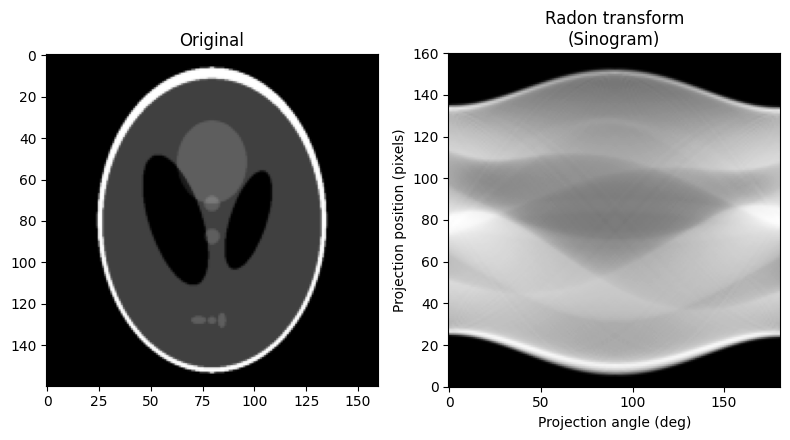

In [361]:


from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', channel_axis=None)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0.0, 180.0, max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(
    sinogram,
    cmap=plt.cm.Greys_r,
    extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
    aspect='auto',
)

fig.tight_layout()
plt.show()

In [362]:
write_vector(sinogram, 'test.txt')

In [363]:
def rotate_theta(theta: float) -> np.ndarray:
    """generate all rotation matrices for the angles in theta
    
    returns: (len(theta), 2, 2) matrix of stacked 2x2 rotation matrices
    """
    return np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)],
        ], dtype=np.float64)

In [364]:
def pixel_center(N: int, ij: np.ndarray) -> np.ndarray:
    return ij - (N >> 1) + 0.5

In [365]:
def radon(image: np.ndarray, angles: np.array = np.arange(180)):
    N = None
    if image.ndim == 1:
        if int(np.sqrt(image.shape[0]))**2 != image.shape[0]:
            raise ValueError("Provided image is not square.")
        N = int(np.sqrt(image.shape[0]))
    elif image.ndim == 2:
        if image.shape[0] != image.shape[1]:
            raise ValueError("Provided image is not square.")
        N = int(image.shape[0])
        image = image.flatten('F')
    elif image.ndim not in [1,2]:
        raise ValueError("Provided image is not a valid picture of dim NxN")
    
    S = int(2 * np.ceil(N/np.sqrt(2)))
    T = len(angles)
    # print(f"N:{N}\nS:{S}\nT:{T}")

    radon_matrix = np.zeros((T*S,N*N))
    indices = np.fromiter(product(range(N), repeat=2), dtype=(np.float64, 2))
    coords = pixel_center(N, indices)

    rot_mats = np.fromiter(map(rotate_theta, angles), dtype=(np.float64, (2,2)))
    radon_data = np.floor(np.matmul(rot_mats, coords.T)[:,0,:]).astype(np.int16) + S // 2
    # print(radon_data)

    for t, rotated in enumerate(radon_data):
        for i, s in enumerate(rotated):
            radon_matrix[t*S+s][i] += 1
    # print(radon_matrix.shape)
    # print((radon_matrix @ image).reshape(T, S).shape)
    
    return (radon_matrix @ image).reshape(T, S).T

In [366]:
from skimage.transform import rotate
def discrete_radon_transform(image, steps):
    R = np.zeros((steps, len(image)), dtype='float64')
    for s in range(steps):
        rotation = rotate(image, -s*180/steps).astype('float64')
        R[:,s] = sum(rotation)
    return R

In [367]:
# image = shepp_logan_phantom()
# image = rescale(image, scale=0.4, mode='reflect', channel_axis=None)

In [368]:
l = 10
image = np.zeros((100,100))

_ = np.linspace(-1,1, image.shape[0])
xv,yv = np.meshgrid(_,_)
xv -= 0.1
yv -= 0.2
image[xv**2+yv**2<0.1] = 1


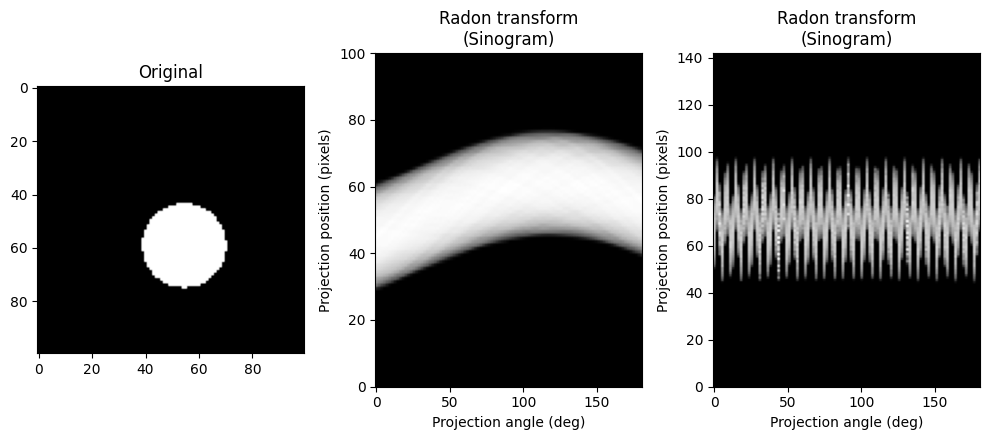

In [369]:
from skimage.data import shepp_logan_phantom
from skimage.transform import radon as working_radon

# image = shepp_logan_phantom()
# image = rescale(image, scale=0.4, mode='reflect', channel_axis=None)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0.0, 180.0, max(image.shape), endpoint=False)
sinogram = discrete_radon_transform(image, max(image.shape))
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(
    sinogram,
    cmap=plt.cm.Greys_r,
    extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
    aspect='auto',
)

sino = radon(image, theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sino.shape[0]
ax3.set_title("Radon transform\n(Sinogram)")
ax3.set_xlabel("Projection angle (deg)")
ax3.set_ylabel("Projection position (pixels)")
ax3.imshow(
    sino,
    cmap=plt.cm.Greys_r,
    extent=(-dx, 180.0 + dx, -dy, sino.shape[0] + dy),
    aspect='auto',
)

fig.tight_layout()
plt.show()

In [370]:
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale

image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', channel_axis=None)

In [371]:
import math
import numpy as np
from PIL import Image

def bilinear_interpolate(img, x, y):
    x0 = int(np.floor(x))
    x1 = x0 + 1
    y0 = int(np.floor(y))
    y1 = y0 + 1

    if x0 < 0 or x1 >= img.shape[1] or y0 < 0 or y1 >= img.shape[0]:
        return 0.0  # or use a default background value

    Ia = img[y0, x0]
    Ib = img[y1, x0]
    Ic = img[y0, x1]
    Id = img[y1, x1]

    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    return wa * Ia + wb * Ib + wc * Ic + wd * Id

def rotate_image(image, angle):
    # Convert angle to radians
    angle_rad = math.radians(angle)

    # Image dimensions
    height, width = image.shape

    # Calculate the new image dimensions
    new_width = int(abs(width * math.cos(angle_rad)) + abs(height * math.sin(angle_rad)))
    new_height = int(abs(width * math.sin(angle_rad)) + abs(height * math.cos(angle_rad)))

    # Create an empty image with the new dimensions
    rotated_image = np.zeros((new_height, new_width), dtype=image.dtype)

    # Center of the image
    cx, cy = width / 2, height / 2
    new_cx, new_cy = new_width / 2, new_height / 2

    # Perform the rotation
    for i in range(new_height):
        for j in range(new_width):
            # Compute the corresponding coordinates in the original image
            x = (j - new_cx) * math.cos(angle_rad) + (i - new_cy) * math.sin(angle_rad) + cx
            y = -(j - new_cx) * math.sin(angle_rad) + (i - new_cy) * math.cos(angle_rad) + cy

            # Get the pixel value using bilinear interpolation
            if 0 <= x < width and 0 <= y < height:
                rotated_image[i, j] = bilinear_interpolate(image, x, y)
                

    return rotated_image

def rotate_image(image, angle):
    # Convert angle to radians
    angle_rad = math.radians(angle)

    # Image dimensions
    height, width = image.shape

    # Calculate the new image dimensions
    new_width = int(abs(width * math.cos(angle_rad)) + abs(height * math.sin(angle_rad)))
    new_height = int(abs(width * math.sin(angle_rad)) + abs(height * math.cos(angle_rad)))

    # Create an empty image with the new dimensions
    rotated_image = np.zeros((new_height, new_width), dtype=image.dtype)

    # Center of the image
    cx, cy = width / 2, height / 2
    new_cx, new_cy = new_width / 2, new_height / 2

    # Perform the rotation
    for i in range(new_height):
        for j in range(new_width):
            # Compute the corresponding coordinates in the original image
            x = (j - new_cx) * math.cos(angle_rad) + (i - new_cy) * math.sin(angle_rad) + cx
            y = -(j - new_cx) * math.sin(angle_rad) + (i - new_cy) * math.cos(angle_rad) + cy

            # Get the nearest neighbor pixel value
            x = round(x)
            y = round(y)

            if 0 <= x < width and 0 <= y < height:
                rotated_image[i, j] = image[y, x]

    return rotated_image

# Rotate the image
angle = 45
rotated_image = rotate_image(image, angle)


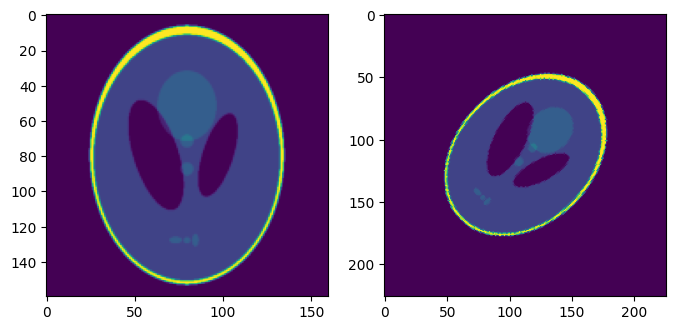

In [372]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
ax1.imshow(image)
ax2.imshow(rotated_image)